In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from auxiliary import plot_cm, plot_nn_metrics, plot_roc, save_metrics, drop_var_nonobj, drop_var_obj

import os
import tempfile

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
#Change path according to directory used
path = r'C:\Users\henri\OneDrive\Documentos\EDSA\EDS Bootcamp\Project\Data\HR_DS.csv'
df = pd.read_csv(path)

In [4]:
# Remove non object variables with no variability
drop_var_nonobj(df)

2 columns, ['EmployeeCount', 'StandardHours'] were droped


In [5]:
# Remove object variables with no variability
drop_var_obj(df)

The ['Over18'] column was droped.


In [6]:
objects = df.describe(include='O').columns.tolist()
non_objs = df.describe().columns.tolist()

patterns = [' ', 'Travel_', '-', '&']

for p in patterns:
    df[objects] = df[objects].apply(lambda x: x.str.replace(p, ''))
    print('Pattern "{}" cleared.'.format(p))

Pattern " " cleared.
Pattern "Travel_" cleared.
Pattern "-" cleared.
Pattern "&" cleared.


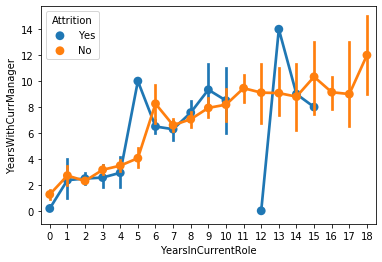

In [7]:
sb.pointplot(df.YearsInCurrentRole, df.YearsWithCurrManager, hue=df.Attrition)
plt.show()

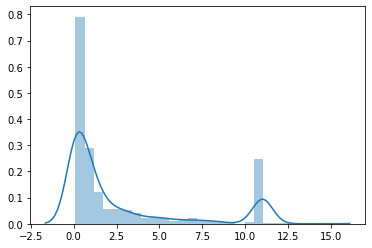

In [8]:
sb.distplot((df.TotalWorkingYears-df.YearsAtCompany+0.1)/(df.NumCompaniesWorked+0.1))
plt.show()

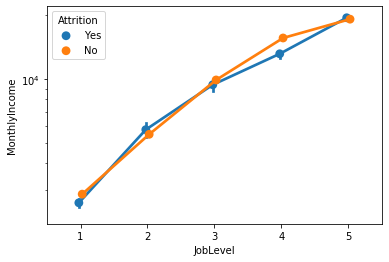

In [9]:
sb.pointplot(df.JobLevel, df.MonthlyIncome, hue=df.Attrition, dodge=True)
plt.yscale('log')
plt.show()

In [10]:
# Score that evaluates the number of years per companies
# The lower the score, the less stable/unexperienced the employee is
# The higher the score, the most stable/experienced the employee it
df['StayScore']=((df.TotalWorkingYears-df.YearsAtCompany)/(df.NumCompaniesWorked+1))

In [11]:
df.StayScore.describe()

count    1470.000000
mean        1.035314
std         1.430512
min         0.000000
25%         0.000000
50%         0.600000
75%         1.000000
max        10.000000
Name: StayScore, dtype: float64

In [12]:
df.drop(columns=['JobLevel', 'EmployeeNumber', 'TotalWorkingYears', 'NumCompaniesWorked'], inplace=True)

In [13]:
objects = df.describe(include='O').columns.tolist()
non_objs = df.describe().columns.tolist()

In [14]:
minmax = MinMaxScaler()
df_pre_ss = pd.concat([df[objects], pd.DataFrame(minmax.fit_transform(df[non_objs]), columns=df[non_objs].columns)], axis=1, sort=False)

Making some dummies

In [15]:
finaldf = pd.get_dummies(df_pre_ss, drop_first=True)

In [16]:
n_features = len(finaldf.columns)
n_features

43

# Models Testing (Train, Val, Test)
First, the dataset has to be split into 3 sets of data so that the following is available for every model:
* A train dataset (features and labels appart) (80%)
* A validation dataset (features and labels appart) (10%)
    * Will be used to validate the train dataset
* A test dataset (features and labels appart) (10%)
    * Will be used to test the final models as an out of sample dataset.
    
Further on, the models will be evaluated on using Stratified K Fold Testing (90% to 10%)

In [17]:
# test 10%; val 10%; train 80%
train_df, test_df = train_test_split(finaldf, test_size=0.1, random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=123)

# Form np arrays of labels and features
train_labels = np.array(train_df.pop('Attrition_Yes'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Attrition_Yes'))
test_labels = np.array(test_df.pop('Attrition_Yes'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)
print('')
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (1190,)
Validation labels shape: (133,)
Test labels shape: (147,)

Training features shape: (1190, 42)
Validation features shape: (133, 42)
Test features shape: (147, 42)


A check on the imbalance of the datasets is needed

In [18]:
neg, pos = np.bincount(finaldf.Attrition_Yes)
total = neg + pos
print('Cases on full dataset:\n    Total: {}\n    Employees that Left the company: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Cases on full dataset:
    Total: 1470
    Employees that Left the company: 237 (16.12% of total)



In [19]:
neg, pos = np.bincount(test_labels)
total = neg + pos
print('Cases on test dataset:\n    Total: {}\n    Employees that Left the company: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Cases on test dataset:
    Total: 147
    Employees that Left the company: 17 (11.56% of total)



In [20]:
neg, pos = np.bincount(val_labels)
total = neg + pos
print('Cases on validation dataset:\n    Total: {}\n    Employees that Left the company: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Cases on validation dataset:
    Total: 133
    Employees that Left the company: 23 (17.29% of total)



In [21]:
neg, pos = np.bincount(train_labels)
total = neg + pos
print('Cases on training dataset:\n    Total: {}\n    Employees that Left the company: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Cases on training dataset:
    Total: 1190
    Employees that Left the company: 197 (16.55% of total)



A determination of the weights of the target label will be important further on the testing of the models

In [22]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2
weight_for_1 = (1 / pos)*(total)/2

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (Stayers): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (Leavers): {:.2f}'.format(weight_for_1))

Weight for class 0 (Stayers): 0.60
Weight for class 1 (Leavers): 3.02


In [23]:
# initialization of the dataframe to store the metrics for each model evaluated on test split
models_summary = pd.DataFrame(columns=['model','tp', 'fp', 'tn', 'fn', 
                                       'acc', 'prec', 'recall', 'auc', 'f1', 'mc_coef', 
                                       'batch_s'])

## 7. Keras Tensorflow Classification NN

In [24]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [25]:
# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(Dense(train_features.shape[-1], input_dim=train_features.shape[-1], activation='relu'))
    #model.add(Dense(24, activation='relu'))
    #model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [26]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

X = train_features
Y = train_labels

### GridSearch with Stratified K-Fold CV

In [27]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters

batch_size = [16, 32, 64, 128, 256]
epochs = [10, 50, 100]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

param_grid = dict(batch_size=batch_size,
                  epochs=epochs)#,
                  #optimizer=optimizer,
                  #init_mode=init_mode)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=StratifiedKFold(n_splits=5, shuffle=True))
grid_result = grid.fit(X, Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [ ]:
BATCH = grid_result.best_params_['batch_size']
EPOCHS = grid_result.best_params_['epochs']

In [ ]:
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(train_features.shape[-1], input_dim=train_features.shape[-1], activation='relu'))
    #model.add(Dense(24, activation='relu'))
    #model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BATCH, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle=True))
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
OPTIM = grid_result.best_params_['optimizer']

In [ ]:
from keras.optimizers import Adadelta

def create_model(learn_rate=0.01, momentum=0):
    model = Sequential()
    model.add(Dense(train_features.shape[-1], input_dim=train_features.shape[-1], activation='relu'))
    #model.add(Dense(24, activation='relu'))
    #model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = Adadelta(lr=learn_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BATCH, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle=True))
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
LearnR = grid_result.best_params_['learn_rate']

In [ ]:
def create_model(init_mode='uniform'):
    model = Sequential()
    model.add(Dense(train_features.shape[-1], input_dim=train_features.shape[-1], kernel_initializer=init_mode, activation='relu'))
    #model.add(Dense(24, activation='relu'))
    #model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    # Compile model
    optimizer = Adadelta(lr=LearnR)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BATCH, verbose=0)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle=True))
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
INIT = grid_result.best_params_['init_mode']

In [ ]:
def create_model(activation='relu'):
    model = Sequential()
    model.add(Dense(train_features.shape[-1], input_dim=train_features.shape[-1], kernel_initializer=INIT, activation=activation))
    #model.add(Dense(24, activation='relu'))
    #model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, kernel_initializer=INIT, activation='sigmoid'))
    # Compile model
    optimizer = Adadelta(lr=LearnR)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BATCH, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle=True))
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
ACTIV = grid_result.best_params_['activation']

In [ ]:
from keras.constraints import maxnorm

def create_model(dropout_rate=0.0, weight_constraint=0):
    model = Sequential()
    model.add(Dense(train_features.shape[-1], input_dim=train_features.shape[-1], kernel_initializer=INIT, activation=ACTIV, kernel_constraint=maxnorm(weight_constraint)))
    #model.add(Dense(24, activation='relu'))
    #model.add(Dense(4, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer=INIT, activation='sigmoid'))
    # Compile model
    optimizer = Adadelta(lr=LearnR)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BATCH, verbose=0)
# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle=True))
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
DROPOUT, W_CONSTRAIN = grid_result.best_params_['dropout_rate'], grid_result.best_params_['weight_constraint']

In [ ]:
def create_model(neurons=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=train_features.shape[-1], kernel_initializer=INIT, activation=ACTIV, kernel_constraint=maxnorm(W_CONSTRAIN)))
    #model.add(Dense(24, activation='relu'))
    #model.add(Dense(0, activation='relu'))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1, kernel_initializer=INIT, activation='sigmoid'))
    # Compile model
    optimizer = Adadelta(lr=LearnR)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BATCH, verbose=0)
# define the grid search parameters
neurons = [i for i in range(2, train_features.shape[-1]+2, 2)]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle=True))
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
def create_model(f_neurons=1, fh_neurons=1, drop=0.2):
    model = Sequential()
    model.add(Dense(f_neurons, input_dim=train_features.shape[-1], kernel_initializer=INIT, activation=ACTIV, kernel_constraint=maxnorm(W_CONSTRAIN)))
    model.add(Dense(fh_neurons, activation=ACTIV))
    #model.add(Dense(0, activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(1, kernel_initializer=INIT, activation='sigmoid'))
    # Compile model
    optimizer = Adadelta(lr=LearnR)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BATCH, verbose=0)
# define the grid search parameters
f_neurons = [i for i in range(2, train_features.shape[-1]+2, 2)]
fh_neurons = [i for i in range(2, int((train_features.shape[-1]+2)/2), 2)]
dropout_rate = [0.0, 0.2, 0.25, 0.4, 0.5]
param_grid = dict(f_neurons=f_neurons, fh_neurons=fh_neurons, drop=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle=True))
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))